# ECG Feature Extraction

This notebook performs feature extraction for multilead ECG signals using prior preprocessing.

### What we have:
- Input data is already resampled to 250 Hz
- Bandpass filtering has been applied
- Signals are in NumPy array format `[samples, timepoints, leads]`

### What this notebook will do:
1. Load the preprocessed signals
2. Apply SAK segmentation (P-QRS-T)
3. Extract key morphological features per lead
4. Visualize signal + segmentation masks
5. Save `all_features.csv`


In [2]:
import pickle
import numpy as np
import pandas as pd
import torch
import sak
import matplotlib.pyplot as plt
from typing import List
from pathlib import Path

# Load pretrained SAK models
model_dir = "data/modelos"
models = [torch.load(f"{model_dir}/model.{i+1}") for i in range(5)]
print("Loaded SAK models.")

/var/folders/gy/5nns71_n7nx_v_2mkns5_k340000gn/T/ipykernel_33759/475153508.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models = [torch.load(f"{model_dir}/model.{i+1

Loaded SAK models.


/Users/taniapazospuig/anaconda3/envs/CompBioMed25/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/var/folders/gy/5nns71_n7nx_v_2mkns5_k340000gn/T/ipykernel_33759/475153508.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlis

In [5]:
# Load the preprocessed signal array
with open("processed_data_big_dataset/df_signals_preprocessed.pkl", "rb") as f:
    df_signals = pickle.load(f)

print(f"Loaded df_signals with shape: {df_signals.shape}")

Loaded df_signals with shape: (29153, 18)


### Step 1: Load Preprocessed ECGs

In [ ]:
# Load preprocessed_ecgs.pkl
with open("processed_data_big_dataset/preprocessed_ecgs.pkl", "rb") as f:
    ecg_signals_all = pickle.load(f)

### Step 2: Define segmentation function from ECGExample

In [23]:
from sak.signal.interpolate import interp1d
import skimage.util
import math
import scipy.signal as sp

def predict_ecg(ecg, fs=250, model=None, window_size=2048, stride=256, threshold_ensemble=0.5,
                thr_dice=0.9, ptg_voting=0.5, batch_size=16):
    
    if ecg.shape[0] < 50: # Skip very short signals
        raise ValueError(f"Signal too short for segmentation: {ecg.shape}")
    
    # Make sure shape is [time, leads]
    ecg = np.copy(ecg)
    if ecg.ndim == 2 and ecg.shape[0] < ecg.shape[1]:
        ecg = ecg.T
    ecg = ecg[:, :12]  # Only first 12 leads

    # Pad if needed
    N = ecg.shape[0]
    # Pad to make the length a multiple of window size
    if N < window_size:
        pad = math.ceil(N / window_size) * window_size - N
        ecg = np.pad(ecg, ((0, pad), (0, 0)), mode='edge')
    # Also make sure the overlapping windows line up with the stride
    if (ecg.shape[0] - window_size) % stride != 0:
        pad = math.ceil((ecg.shape[0] - window_size) / stride) * stride - (ecg.shape[0] % window_size)
        ecg = np.pad(ecg, ((0, pad), (0, 0)), mode='edge')

    # Windowing
    windowed = skimage.util.view_as_windows(ecg, (window_size, ecg.shape[1]), step=(stride, 1))
    windowed = windowed[:, 0, :, :]  # Remove the singleton dimension (n_windows, 2048, 12)
    windowed = np.swapaxes(windowed, 1, 2) # Shape becomes (n_windows, 12, 2048)

    # Predict with models
    # Each model outputs a prediction for 3 channels (P, QRS, T)
    mask = np.zeros((windowed.shape[0], 3, window_size), dtype=int)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Loop over all models and batches
    with torch.no_grad():
        for m in model:
            m = m.to(device)
            for i in range(0, windowed.shape[0], batch_size):
                inputs = {"x": torch.tensor(windowed[i:i+batch_size]).float().to(device)}
                outputs = m(inputs)["sigmoid"].cpu().numpy()
                # Apply threshold to convert probabilities to binary
                # Accumulate votes (how many models say "yes" to a region)
                mask[i:i+batch_size] += outputs > thr_dice
        # After all models vote, keep only regions where enough models agreed
        mask = mask >= len(model) * threshold_ensemble

    # Reconstruct full signal
    full_mask = np.zeros((3, ecg.shape[0]))
    counter = np.zeros(ecg.shape[0])
    # For each window, place its mask into the right location in the full signal
    for i in range(0, mask.shape[0]):
        start = i * stride
        full_mask[:, start:start+window_size] += mask[i]
        counter[start:start+window_size] += 1 # Count how many times each timepoint has been covered since windows overlap
    full_mask = (full_mask / counter) > ptg_voting # Normalize votes and apply final threshold for each timepoint
    full_mask = full_mask[:, :N] # Trim to original signal length

    # Clean up extra dimensions
    if full_mask.ndim == 3 and full_mask.shape[-1] == 1:
        full_mask = full_mask.squeeze(-1)

    return full_mask

`full_mask` will have shape [3, time], where each row corresponds to:
- Row 0: P wave
- Row 1: QRS complex
- Row 2: T wave

Each element is True or False, indicating whether that timepoint belongs to that segment (e.g., is part of a QRS complex).

### Step 3: Visualize Segmentation

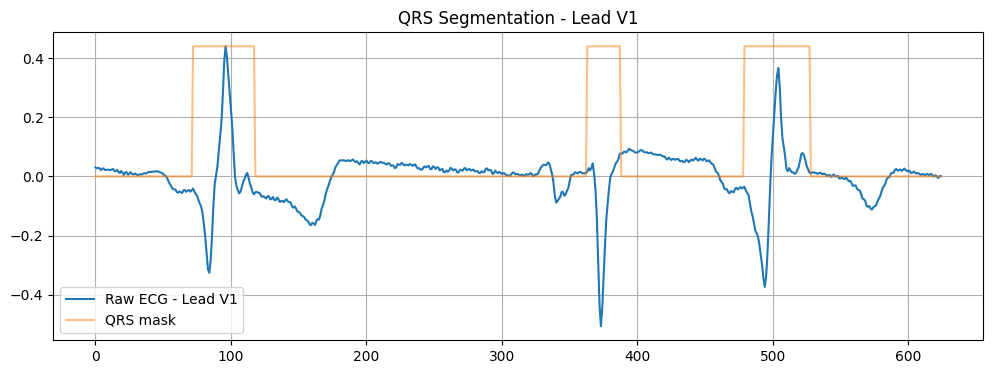

In [9]:
# Visualize segmentation for Lead V1
# Assumes ecg_signals_all and models are loaded

# Select the first ECG sample
signal = ecg_signals_all[0]  # shape: (625, 12)

# Extract Lead V1 (column 6)
lead_v1 = signal[:, 6][:, np.newaxis]  # shape: (625, 1)

# Run SAK segmentation on the single lead
mask = predict_ecg(lead_v1, model=models)

# Plot signal and QRS mask overlay
plt.figure(figsize=(12, 4))
plt.plot(lead_v1, label='Raw ECG - Lead V1')
plt.plot(mask[1] * np.max(lead_v1), label='QRS mask', alpha=0.5)
plt.title("QRS Segmentation - Lead V1")
plt.legend()
plt.grid(True)
plt.show()

### Step 4: Extract Morphological Features

In [24]:
def extract_morph_features(signal, mask, fs=250):
    """
    Extracts morphological ECG features from each lead based on segmentation masks.

    Parameters:
        signal: np.ndarray of shape (T, 12) or (T,) — ECG signal.
        mask: np.ndarray of shape (3, T) — binary mask for P, QRS, and T segments.
        fs: Sampling frequency (Hz).

    Returns:
        features: dict of extracted features per lead + global features.
    """
    
    features = {}
    transition_found = False
    precordial_index = -1

    lead_names = ["I", "II", "III", "AVR", "AVL", "AVF", "V1", "V2", "V3", "V4", "V5", "V6"]

    for i, lead in enumerate(lead_names):
        # Handle both 1D and 2D signals
        if signal.ndim == 1:  # Single-lead case
            lead_signal = signal
        elif signal.shape[1] == 1:  # Single-lead with shape (T, 1)
            lead_signal = signal[:, 0]
        else:  # Multi-lead case
            lead_signal = signal[:, i]

        if lead_signal.shape[0] < 10 or mask.shape != (3, lead_signal.shape[0]):
            print(f"[ERROR] Skipping due to malformed signal/mask for lead {lead}")
            raise ValueError(f"Malformed signal or mask for lead {lead}")

        # R and S amplitude + Ratio
        r_peak = np.max(lead_signal)
        s_trough = np.min(lead_signal)
        r_s_ratio = r_peak / abs(s_trough) if s_trough != 0 else 0

        # QRS duration
        qrs_indices = np.where(mask[1])[0]
        qrs_dur = (qrs_indices[-1] - qrs_indices[0]) / fs * 1000 if len(qrs_indices) > 1 else 0

        features[f"{lead}_r_amp"] = r_peak
        features[f"{lead}_s_amp"] = s_trough
        features[f"{lead}_r_s_ratio"] = r_s_ratio
        features[f"{lead}_qrs_dur"] = qrs_dur

        if lead.startswith("V") and not transition_found:
            if r_peak > abs(s_trough):
                precordial_index = int(lead[1:])
                transition_found = True

        t_indices = np.where(mask[2])[0]
        if len(t_indices) > 3:
            t_mean = np.mean(lead_signal[t_indices])
            polarity = 1 if t_mean > 0.02 else (-1 if t_mean < -0.02 else 0)
        else:
            polarity = 0
        features[f"{lead}_t_polarity"] = polarity

    features["precordial_transition"] = precordial_index
    return features

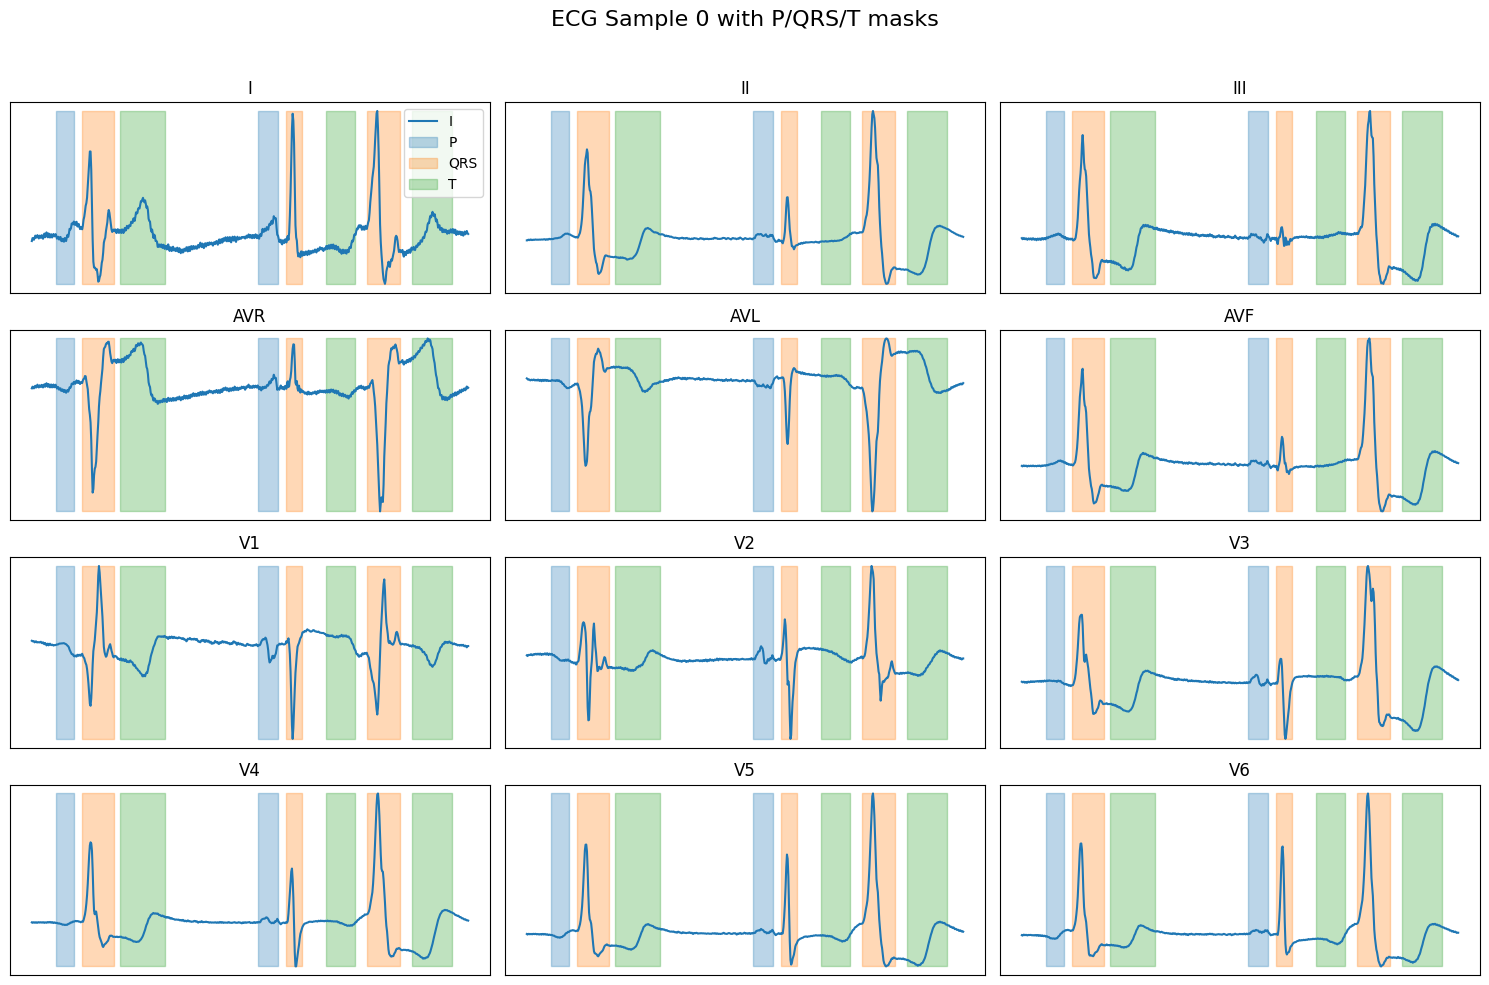

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sak.signal import StandardHeader

# Choose one sample (already shape [625, 12])
sample_index = 0
signal = ecg_signals_all[sample_index]

# Predict masks per lead (example: using V1 only for segmentation to get a common mask)
mask = predict_ecg(signal[:, 6][:, np.newaxis], model=models)  # Use V1 (lead 6) as representative
segmentation = mask  # shape (3, 625)

# Build x-axis (assuming fs = 250 and 625 points, so 2.5 seconds of signal)
fs = 250
x = np.linspace(0, 2.5, signal.shape[0])

# Plot all 12 leads in a 4x3 grid
fig, ax = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle(f"ECG Sample {sample_index} with P/QRS/T masks", fontsize=16)

for i in range(12):
    row, col = divmod(i, 3)
    lead_signal = signal[:, i]

    ax[row, col].plot(x, lead_signal, label=StandardHeader[i])
    ax[row, col].fill_between(x, np.min(lead_signal), np.max(lead_signal),
                              where=(segmentation[0, :] == 1), color='C0', alpha=0.3, label='P')
    ax[row, col].fill_between(x, np.min(lead_signal), np.max(lead_signal),
                              where=(segmentation[1, :] == 1), color='C1', alpha=0.3, label='QRS')
    ax[row, col].fill_between(x, np.min(lead_signal), np.max(lead_signal),
                              where=(segmentation[2, :] == 1), color='C2', alpha=0.3, label='T')
    ax[row, col].set_title(StandardHeader[i])
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

# Add legend to one subplot only
ax[0, 0].legend(loc="upper right")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Step 5: Export Features 

In [26]:
from tqdm import tqdm
import traceback

features_list = [] # Store a dictionary of features for each ECG sample

# Loop over all ECG samples
for i in tqdm(range(len(ecg_signals_all)), desc="Extracting features"):
    signal = ecg_signals_all[i]  # shape (625, 12)
    feats_all_leads = {} # Hold features for this one signal

    try:
        # Loop over each lead (single-lead prediction and feature extraction)
        for j, lead_name in enumerate(["I", "II", "III", "AVR", "AVL", "AVF", "V1", "V2", "V3", "V4", "V5", "V6"]):
            lead = signal[:, j]  # shape (625,)
            if lead.ndim != 1 or lead.shape[0] < 10:
                raise ValueError(f"Invalid lead shape: {lead.shape} for {lead_name}")
            # Lead is 1D, reshaped to 2D ((625, 1)) for the model 
            lead = lead[:, np.newaxis]

            # Uses only this one lead to predict P/QRS/T masks for its own signal
            mask = predict_ecg(lead, model=models)

            # Ensure mask is 2D with 3 rows (P, QRS, T)
            if mask.shape[0] != 3 or mask.shape[1] != signal.shape[0]:
                raise ValueError(f"Invalid mask shape {mask.shape} for lead {lead_name}")

            # Extract morphological features
            feats = extract_morph_features(lead, mask)

            # Prefix feature with lead name
            for k, v in feats.items():
                feats_all_leads[f"{lead_name}_{k}"] = v

        # Track SampleID from the df_signals dataframe
        feats_all_leads["SampleID"] = df_signals.iloc[i]["SampleID"]
        features_list.append(feats_all_leads)

    # If any lead or mask is malformed, skips that ECG
    except Exception as e:
        print(f"\n[ERROR] Skipping sample {i} (SampleID={df_signals.iloc[i]['SampleID']}) due to error:\n{traceback.format_exc()}")

# Create final df
df_feats = pd.DataFrame(features_list)
df_feats.to_csv("all_features.csv", index=False)
print("Saved all_features.csv with shape:", df_feats.shape)

Extracting features:   1%|          | 180/29153 [07:22<19:45:48,  2.46s/it]


KeyboardInterrupt: 